In [2]:
import pandas as pd
import concurrent.futures
import requests
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import warnings
import statsmodels.api as sm

In [3]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sktime.clustering.k_means import TimeSeriesKMeans
from sklearn.metrics import silhouette_samples, silhouette_score, euclidean_distances
from sklearn.decomposition import PCA
from sktime.datatypes import convert_to
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from scipy.stats import pearsonr
from multiprocessing import Pool
from joblib import Parallel, delayed
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.spatial.distance import euclidean
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
#from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_selection import temporal_train_test_split
from pmdarima import auto_arima
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from sktime.forecasting.base import ForecastingHorizon

In [4]:
pair_list = [('JBHT', 'LOW'), ('DHI', 'LEN'), ('IQV', 'LH')]

In [5]:
fct_df  = pd.read_csv("yfinance_data.csv") 

In [6]:
fct_df.columns = fct_df.columns.str.lower()
fct_df  = fct_df[['date','open','close','ticker']]
fct_df['date'] = pd.to_datetime(fct_df['date'], utc=True)
fct_df['date'] = fct_df['date'].dt.tz_localize(None)


In [7]:
min_date = fct_df['date'].min()
max_date = fct_df['date'].max()

train_end = min_date + pd.DateOffset(years=4) 
test_end = max_date

train_df = fct_df[fct_df['date'] <= train_end] 
test_df = fct_df[(fct_df['date'] > train_end)]

print(f'Train period: {min(train_df["date"])} - {max(train_df["date"])}')
print(f'Test period: {min(test_df["date"])} - {max(test_df["date"])}')

Train period: 2018-12-04 05:00:00 - 2022-12-02 05:00:00
Test period: 2022-12-05 05:00:00 - 2023-12-04 05:00:00


In [8]:
def create_log_spread_series(data, pair):
    stock1_data = data[data['ticker'] == pair[0]]
    stock2_data = data[data['ticker'] == pair[1]]
    
    log_spread = np.log(stock1_data['close'].values) - np.log(stock2_data['close'].values)
    log_spread_df = pd.DataFrame({'date': stock1_data['date'], 'log_spread': log_spread})
    
    return log_spread_df

In [9]:
current_pair = pair_list[0]
pair_data = create_log_spread_series(train_df, current_pair)
print(pair_data.head())

                      date  log_spread
327903 2018-12-04 05:00:00    0.139659
327904 2018-12-06 05:00:00    0.160264
327905 2018-12-07 05:00:00    0.142127
327906 2018-12-10 05:00:00    0.142492
327907 2018-12-11 05:00:00    0.129343


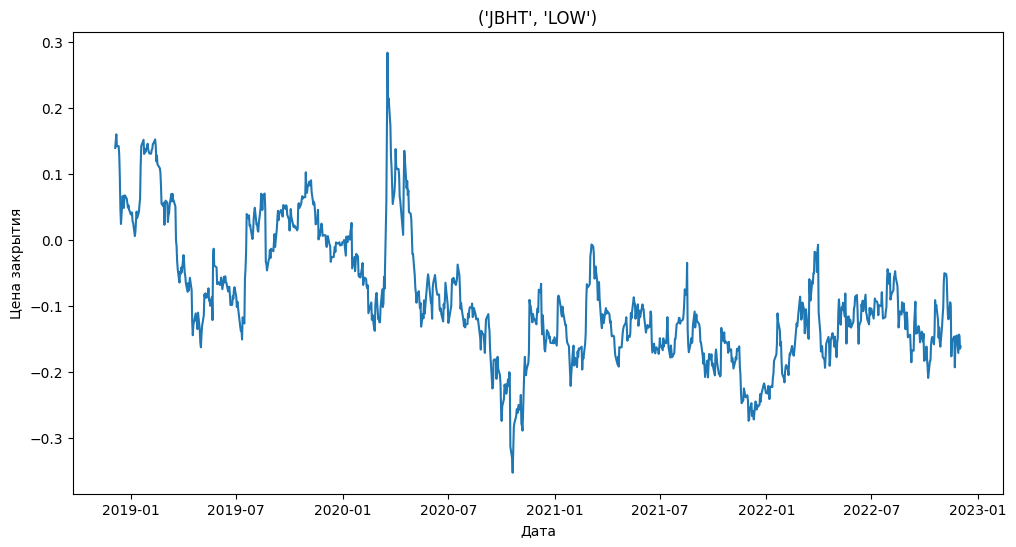

In [10]:
pair_data.set_index('date', inplace=True)
ts = pair_data['log_spread']

plt.figure(figsize=(12, 6))
plt.plot(ts)
plt.title(current_pair)
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.show()

In [11]:
# Проверка стационарности ряда
def test_stationarity(timeseries):
    # Критерий Дики-Фуллера
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

test_stationarity(ts)

Test Statistic                   -4.132577
p-value                           0.000855
#Lags Used                        1.000000
Number of Observations Used    1005.000000
Critical Value (1%)              -3.436873
Critical Value (5%)              -2.864420
Critical Value (10%)             -2.568304
dtype: float64


In [43]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# Создание скользящих средних различных интервалов времени в качестве факторов
rolling_windows = [1, 2, 3, 4, 5, 10, 15, 20, 30, 45, 60]
features = pd.DataFrame(index=ts.index)
for window_size in rolling_windows:
    rolling_mean = ts.rolling(window=window_size).mean().shift(1)
    features[f'rolling_mean_{window_size}'] = rolling_mean.fillna(0)

# Разделение временного ряда на 20 фолдов
n_splits = 20
tscv = TimeSeriesSplit(n_splits=n_splits)

mae_scores = []
directional_accuracies = []

for train_index, test_index in tscv.split(ts):
    # Инициализация модели XGBoost
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

    forecasted_values = []

    for i in range(5):
        # Индексы для обучения модели на текущем шаге
        current_train_index = np.append(train_index, test_index[:i])
        
        # Факторы и целевая переменная для обучения
        X_train = features.iloc[current_train_index]
        y_train = ts.iloc[current_train_index]

        # Обучение модели
        model.fit(X_train, y_train)

        # Создание факторов для прогнозирования следующего дня
        X_test = features.iloc[test_index[i:i+1]]

        # Прогноз следующего дня
        forecast = model.predict(X_test)
        forecasted_values.append(forecast[0])

    # Оценка MAE
    test_data = ts.iloc[test_index[:5]]
    mae = mean_absolute_error(test_data, forecasted_values)
    mae_scores.append(mae)

    # Оценка процента угадывания изменения направления
    if len(test_data) > 1:  # Убедимся, что есть достаточно данных для вычисления направления
        true_directions = np.sign(np.diff(test_data.values))
        predicted_directions = np.sign(np.diff(forecasted_values))
        if len(true_directions) == len(predicted_directions):
            accuracy = np.sum(true_directions == predicted_directions) / len(true_directions)
            directional_accuracies.append(accuracy)
        else:
            directional_accuracies.append(np.nan)  # Недостаточно данных для вычисления

# Вывод средних метрик
print(f'Средний MAE: {np.nanmean(mae_scores)}')
print(f'Средний процент угадывания изменения направления: {np.nanmean(directional_accuracies)}')


C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorical

Средний MAE: 0.02095446557261105
Средний процент угадывания изменения направления: 0.525


C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorical

In [46]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# Ваш временной ряд ts
# Пример: ts = pd.Series(data, index=dates)
# Убедитесь, что ts - это pandas Series с временными метками

# Создание скользящих средних различных интервалов времени в качестве факторов
rolling_windows = [1, 3, 5, 10, 15, 20, 25, 30, 40, 50, 60]
features = pd.DataFrame(index=ts.index)
for window_size in rolling_windows:
    rolling_mean = ts.rolling(window=window_size).mean().shift(1)
    features[f'rolling_mean_{window_size}'] = rolling_mean.fillna(0)

# Разделение временного ряда на 20 фолдов
n_splits = 20
tscv = TimeSeriesSplit(n_splits=n_splits)

mae_scores = []
directional_accuracies = []

for train_index, test_index in tscv.split(ts):
    # Инициализация модели XGBoost
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

    forecasted_values = []

    for i in range(5):
        # Индексы для обучения модели на текущем шаге
        current_train_index = np.append(train_index, test_index[:i])
        
        # Факторы и целевая переменная для обучения
        X_train = features.iloc[current_train_index]
        y_train = ts.iloc[current_train_index]

        # Обучение модели
        model.fit(X_train, y_train)

        # Создание факторов для прогнозирования следующего дня
        X_test = features.iloc[test_index[i:i+1]]

        # Прогноз следующего дня
        forecast = model.predict(X_test)
        forecasted_values.append(forecast[0])

    # Оценка MAE
    test_data = ts.iloc[test_index[:5]]
    mae = mean_absolute_error(test_data, forecasted_values)
    mae_scores.append(mae)

    # Оценка процента угадывания изменения направления
    if len(test_data) > 1:  # Убедимся, что есть достаточно данных для вычисления направления
        true_directions = np.sign(np.diff(test_data.values))
        predicted_directions = np.sign(np.diff(forecasted_values))
        if len(true_directions) == len(predicted_directions):
            accuracy = np.sum(true_directions == predicted_directions) / len(true_directions)
            directional_accuracies.append(accuracy)
        else:
            directional_accuracies.append(np.nan)  # Недостаточно данных для вычисления

# Вывод средних метрик
print(f'Средний MAE: {np.nanmean(mae_scores)}')
print(f'Средний процент угадывания изменения направления: {np.nanmean(directional_accuracies)}')


C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorical

Средний MAE: 0.021405148045455187
Средний процент угадывания изменения направления: 0.5125


C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorical

In [47]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# Ваш временной ряд ts
# Пример: ts = pd.Series(data, index=dates)
# Убедитесь, что ts - это pandas Series с временными метками

# Создание скользящих средних различных интервалов времени в качестве факторов
rolling_windows = [1, 3, 5, 10, 15, 20, 25, 30, 40, 50, 60]
features = pd.DataFrame(index=ts.index)
for window_size in rolling_windows:
    rolling_mean = ts.rolling(window=window_size).mean().shift(1)
    features[f'rolling_mean_{window_size}'] = rolling_mean.fillna(0)

# Разделение временного ряда на 20 фолдов
n_splits = 20
tscv = TimeSeriesSplit(n_splits=n_splits)

mae_scores = []
directional_accuracies = []

for train_index, test_index in tscv.split(ts):
    # Инициализация модели XGBoost
    params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'alpha': 0,
    'lambda': 1,
    'objective': 'reg:squarederror'
    }

    model = XGBRegressor(**params)

    forecasted_values = []

    for i in range(5):
        # Индексы для обучения модели на текущем шаге
        current_train_index = np.append(train_index, test_index[:i])
        
        # Факторы и целевая переменная для обучения
        X_train = features.iloc[current_train_index]
        y_train = ts.iloc[current_train_index]

        # Обучение модели
        model.fit(X_train, y_train)

        # Создание факторов для прогнозирования следующего дня
        X_test = features.iloc[test_index[i:i+1]]

        # Прогноз следующего дня
        forecast = model.predict(X_test)
        forecasted_values.append(forecast[0])

    # Оценка MAE
    test_data = ts.iloc[test_index[:5]]
    mae = mean_absolute_error(test_data, forecasted_values)
    mae_scores.append(mae)

    # Оценка процента угадывания изменения направления
    if len(test_data) > 1:  # Убедимся, что есть достаточно данных для вычисления направления
        true_directions = np.sign(np.diff(test_data.values))
        predicted_directions = np.sign(np.diff(forecasted_values))
        if len(true_directions) == len(predicted_directions):
            accuracy = np.sum(true_directions == predicted_directions) / len(true_directions)
            directional_accuracies.append(accuracy)
        else:
            directional_accuracies.append(np.nan)  # Недостаточно данных для вычисления

# Вывод средних метрик
print(f'Средний MAE: {np.nanmean(mae_scores)}')
print(f'Средний процент угадывания изменения направления: {np.nanmean(directional_accuracies)}')


C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorical

Средний MAE: 0.019411377198511142
Средний процент угадывания изменения направления: 0.5375


C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\serga\anaconda3\envs\PairTradingProject\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorical

In [45]:
forecasted_values

[-0.13265358, -0.1550628, -0.14806545, -0.18961743, -0.17813942]